# Imports

In [1]:
!pip install nltk rouge_score -q

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding ,GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout


from sklearn.model_selection import train_test_split
import pickle
from nltk.translate.bleu_score import sentence_bleu


# Load Datasets

In [3]:
with open('/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/english-corpus.txt', 'r',encoding="utf8") as file:
    english_lines = file.readlines()
with open('/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/urdu-corpus.txt', 'r',encoding="utf8") as file:
    urdu_lines = file.readlines()
    
df = pd.DataFrame({'English': english_lines, 'Urdu': urdu_lines})
df['English'] = df['English'].str.strip()
df['Urdu'] = df['Urdu'].str.strip()

df.head()

,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [4]:
eng = df['English']
urdu = df['Urdu']

# Data Preprocessing

In [5]:
# Tokenizing Urdu sentences
urdu_tokenizer = Tokenizer()
urdu_tokenizer.fit_on_texts(df['Urdu'])
tokenized_urdu_sentences = urdu_tokenizer.texts_to_sequences(df['Urdu'])

# Tokenizing English sentences
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(df['English'])
tokenized_english_sentences = english_tokenizer.texts_to_sequences(df['English'])


# Padding Urdu sentences
preproc_urdu_sentences = pad_sequences(tokenized_urdu_sentences, maxlen=10, padding='post')

# Padding English sentences
preproc_english_sentences = pad_sequences(tokenized_english_sentences, maxlen=10, padding='post')

In [6]:

# Getting sequence lengths and vocabulary sizes
max_english_sequence_length = preproc_english_sentences.shape[1]
max_urdu_sequence_length = preproc_urdu_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
urdu_vocab_size = len(urdu_tokenizer.word_index)

# Model Building And Training

In [11]:

# Defining model parameters
learning_rate = 0.001
input_shape = preproc_english_sentences.shape
output_sequence_length = preproc_urdu_sentences.shape[1]
urdu_vocab_size = len(urdu_tokenizer.word_index) + 1
english_vocab_size = len(english_tokenizer.word_index) + 1

# Creating the model
model = Sequential()
model.add(Embedding(english_vocab_size, 256))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(TimeDistributed(Dense(1024, activation='leaky_relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(urdu_vocab_size, activation='softmax')))

# Compiling the model
model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])

# Adding Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with Early Stopping
history = model.fit(preproc_english_sentences, preproc_urdu_sentences, 
                    batch_size=64, 
                    epochs=100, 
                    validation_split=0.3, 
                    callbacks=[early_stopping])



Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5118 - loss: 3.8121 - val_accuracy: 0.5869 - val_loss: 2.6632
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5917 - loss: 2.5559 - val_accuracy: 0.6176 - val_loss: 2.3745
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6307 - loss: 2.1511 - val_accuracy: 0.6419 - val_loss: 2.1224
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6603 - loss: 1.8470 - val_accuracy: 0.6637 - val_loss: 1.9552
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6866 - loss: 1.5813 - val_accuracy: 0.6776 - val_loss: 1.8576
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7089 - loss: 1.3672 - val_accuracy: 0.6857 - val_loss: 1.7897
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7314 - loss: 1.1881 - val_accuracy: 0.6948 - val_loss: 1.7645
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7557 - loss: 1.0245 -

# Evaluation

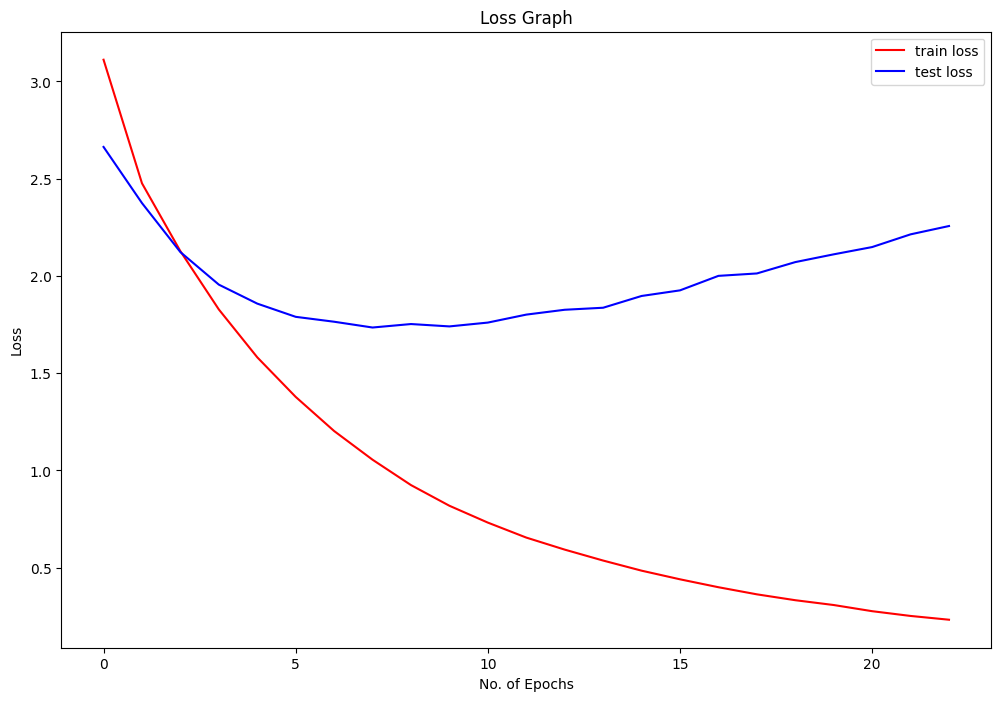

In [12]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();


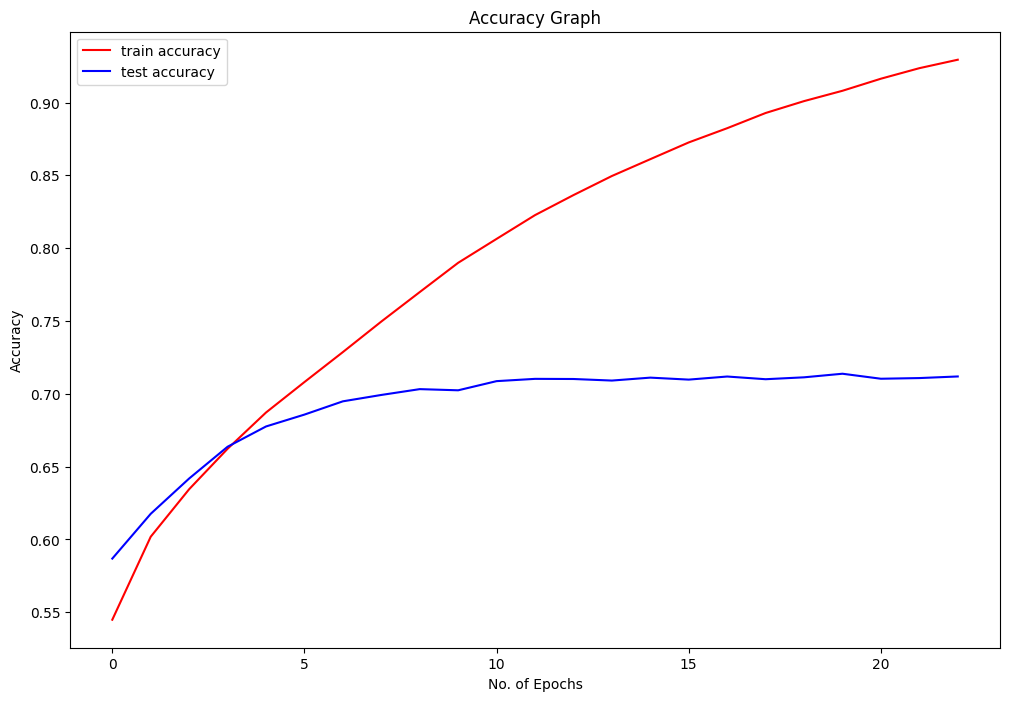

In [13]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [14]:
# Saving the model
model.save('english_to_urdu_translator_final.h5')

pickle.dump(english_tokenizer,open("english_tokenizer.pkl",'wb'))
pickle.dump(urdu_tokenizer,open("urdu_tokenizer.pkl",'wb'))

# Real Time Translation System

In [18]:
import numpy as np


# Load the trained model
model = load_model('english_to_urdu_translator_final.h5')

# Load tokenizers
with open('english_tokenizer.pkl', 'rb') as file:
    english_tokenizer = pickle.load(file)

with open('urdu_tokenizer.pkl', 'rb') as file:
    urdu_tokenizer = pickle.load(file)

# Reverse mapping for Urdu tokenizer (index to word)
urdu_index_to_word = {index: word for word, index in urdu_tokenizer.word_index.items()}

def translate_sentences(sentences):
    # Tokenize input sentences
    sequences = english_tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=10, padding='post')
    
    # Predict Urdu sentences
    predictions = model.predict(padded_sequences)
    
    translated_sentences = []
    for prediction in predictions:
        predicted_words = [urdu_index_to_word.get(np.argmax(word_vec), '') for word_vec in prediction]
        translated_sentence = ' '.join(predicted_words).strip()
        translated_sentences.append(translated_sentence)
    
    return translated_sentences

# Sample 10 English sentences
english_sentences = [
    "is zain your nephew",
    "i wish youd trust me",
    "did he touch you",
    "its part of life",
    "zain isnt ugly",
    "i am in a hurry today",
    "take this medicine",
    "this is the case",
    "zains tipsy",
    "i am not angry"
]

# Translate and print results
urdu_translations = translate_sentences(english_sentences)

for eng, urdu in zip(english_sentences, urdu_translations):
    print(f"English: {eng}\nUrdu: {urdu}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
English: is zain your nephew
Urdu: زین آپ بھتیجا ہے

English: i wish youd trust me
Urdu: مجھے آپ مجھ پر پر

English: did he touch you
Urdu: کیا اس نے آپ کو

English: its part of life
Urdu: اس کی زندگی کی

English: zain isnt ugly
Urdu: زین بدصورت نہیں ہے

English: i am in a hurry today
Urdu: میں اب میں ہوں

English: take this medicine
Urdu: اسے دوا لے لو

English: this is the case
Urdu: یہ معاملہ ہے

English: zains tipsy
Urdu: زین دلچسپ

English: i am not angry
Urdu: میں ناراض نہیں ہوں

